In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

from PIL import Image

import os, time, copy

import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import v2

cudnn.benchmark = True
plt.ion()

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
num_classes = 10
num_epochs = 20
batch_size = 128
learning_rate = 0.001

Using cuda device


# **Xử lí data**

In [3]:
data_dir = "/kaggle/input/handwritten-tl/digits_data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

In [4]:
br = 0.65
ct = 0.6

data_transforms = {
    'train': v2.Compose([
        v2.Resize((224, 224)),
        v2.RandomRotation(10),
        v2.RandomAffine(0, translate=(0.1,0.1)),
        v2.RandomHorizontalFlip(),
        v2.CenterCrop(200),
        v2.ToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Normalize(mean=[0.485,0.456,0.406],
                std =[0.229,0.224,0.225]),
    ]),
    'val': v2.Compose([
        v2.Resize(224),
        v2.CenterCrop(200),
        v2.ToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Normalize(mean=[0.485,0.456,0.406],
                std =[0.229,0.224,0.225]),
    ]),
}

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
def remove_corrupted_images(folder):
    for root, _, files in os.walk(folder):
        for fname in files:
            fpath = os.path.join(root, fname)
            try:
                img = Image.open(fpath)
                img.verify()  # kiểm tra định dạng ảnh
            except Exception as e:
                print(f"🗑️ Xóa ảnh lỗi: {fpath}")
                os.remove(fpath)

remove_corrupted_images(train_dir)
remove_corrupted_images(val_dir)

In [6]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val']),
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x=='train'))
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


# **Transfer learning với Resnet**

In [7]:
weights = MobileNet_V3_Large_Weights.IMAGENET1K_V2
model = mobilenet_v3_large(weights=weights)

for param in model.parameters():
    param.requires_grad = False  # Freeze toàn bộ layers

# Thay lớp fully-connected để phù hợp với 10 lớp
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model = model.to(device)


criterion = nn.CrossEntropyLoss()

# Optim 
# optimizer = optim.Adam(model.classifier[3].parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)



Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 162MB/s]


In [8]:
import sys
import time
import copy
from tqdm import tqdm
from contextlib import redirect_stdout

# Logging class
class DualWriter:
    def __init__(self, file):
        self.file = file
        self.stdout = sys.__stdout__

    def write(self, text):
        self.stdout.write(text)
        self.file.write(text)

    def flush(self):
        self.stdout.flush()
        self.file.flush()

In [9]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, num_epochs, log_path):
    log_file = open(log_path, "a")
    dual_output = DualWriter(log_file)

    with redirect_stdout(dual_output):
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        since = time.time()

        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} Epoch {epoch+1}"):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        preds = torch.argmax(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels).item()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                
                if phase == "val":
                    scheduler.step(epoch_loss)
                    
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print(f'\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        model.load_state_dict(best_model_wts)

    print("🟢 Đã thoát khỏi logging context. Giờ chỉ in ra console.")
    log_file.close()
    return model, best_acc, time_elapsed

In [10]:
# best_model, best_acc, time_elapsed = train_model(model, criterion, optimizer,  
#                                                  exp_lr_scheduler, num_epochs)
log_path = 'train_log.txt'
best_model, best_acc, time_elapsed = train_model(model, criterion, optimizer, num_epochs, log_path)

train Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 1/20


val Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 2.0413 Acc: 0.3093


train Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.8940 Acc: 0.3244

Epoch 2/20


val Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.6981 Acc: 0.4715


train Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.6901 Acc: 0.3878

Epoch 3/20


val Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.5397 Acc: 0.5208


train Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.5799 Acc: 0.4282

Epoch 4/20


val Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.4430 Acc: 0.5588


train Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.5124 Acc: 0.4649

Epoch 5/20


val Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.3894 Acc: 0.5699


train Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.4771 Acc: 0.4756

Epoch 6/20


val Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.3407 Acc: 0.5741


train Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.4463 Acc: 0.5015

Epoch 7/20


val Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.3035 Acc: 0.5833


train Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.4124 Acc: 0.5191

Epoch 8/20


val Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.2691 Acc: 0.5923


train Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.3904 Acc: 0.5221

Epoch 9/20


val Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.2472 Acc: 0.6020


train Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.3652 Acc: 0.5450

Epoch 10/20


val Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.2143 Acc: 0.6156


train Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.3412 Acc: 0.5641

Epoch 11/20


val Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.2070 Acc: 0.6112


train Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.3158 Acc: 0.5733

Epoch 12/20


val Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.1858 Acc: 0.6173


train Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.2901 Acc: 0.5870

Epoch 13/20


val Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.1722 Acc: 0.6250


train Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.2656 Acc: 0.5908

Epoch 14/20


val Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.1807 Acc: 0.6168


train Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.2471 Acc: 0.5954

Epoch 15/20


val Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.1690 Acc: 0.6213


train Epoch 16:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.2256 Acc: 0.6061

Epoch 16/20


val Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.1496 Acc: 0.6317


train Epoch 17:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.2168 Acc: 0.6046

Epoch 17/20


val Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.1317 Acc: 0.6333


train Epoch 18:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.2162 Acc: 0.6053

Epoch 18/20


val Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.1184 Acc: 0.6388


train Epoch 19:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.2111 Acc: 0.6000

Epoch 19/20


val Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.1123 Acc: 0.6368


train Epoch 20:   0%|          | 0/46 [00:00<?, ?it/s]

Val Loss: 1.2074 Acc: 0.5985

Epoch 20/20


val Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 1.1095 Acc: 0.6354


val Epoch 20: 100%|██████████| 11/11 [00:47<00:00,  4.28s/it]

🟢 Đã thoát khỏi logging context. Giờ chỉ in ra console.


# **Lưu:**
- Model
- Best accuracy
- Thời gian chạy
- Optimizer
- Hàm loss
- Transform data

In [11]:
torch.save(model.state_dict(), 'mobilenet_v3_large.pth')

log_path = "final_train_log.txt"
with open(log_path, "a") as f:
    f.write("="*60 + "\n")
    f.write("Training Summary\n")
    f.write("="*60 + "\n")
    f.write(f"Time: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s\n")
    f.write(f"Best Validation Accuracy: {best_acc:.4f}\n")
    f.write(f"\nOptimizer: {optimizer.__class__.__name__} - {optimizer.state_dict()['param_groups'][0]}\n")
    f.write(f"Loss Function: {criterion.__class__.__name__}\n")

    f.write("\nTransforms:\n")
    for phase in ['train', 'val']:
        f.write(f"  {phase}:\n")
        for t in data_transforms[phase].transforms:
            f.write(f"    - {t}\n")

    f.write("="*60 + "\n\n")

# **Test 20 ảnh random trên tập test**

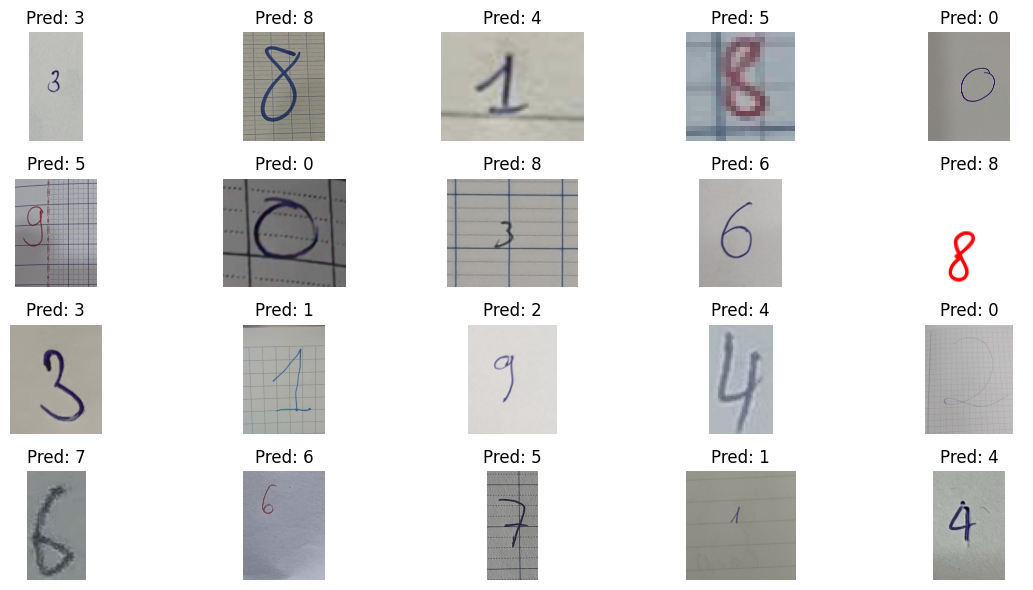

In [12]:
# Định nghĩa thư mục test
test_folder = "/kaggle/input/handwritten-test-10k"

# Thiết bị (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Định nghĩa transform cho test (tương tự 'val')
transform = v2.Compose([
        v2.Resize(224),
        v2.CenterCrop(200),
        v2.ToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Normalize(mean=[0.485,0.456,0.406],
                std =[0.229,0.224,0.225]),
])

# Lấy 20 ảnh ngẫu nhiên từ thư mục test
all_files = [f for f in os.listdir(test_folder)]
random.shuffle(all_files)
selected_files = all_files[:20]

# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Tạo figure để plot
plt.figure(figsize=(12, 6))

# Test và plot từng ảnh
for i, filename in enumerate(selected_files):
    # Đọc ảnh
    img_path = os.path.join(test_folder, filename)
    image = Image.open(img_path).convert("RGB") # Đọc ảnh và chuyển thành grayscale

    # Áp dụng transform
    image_input = transform(image).unsqueeze(0).to(device)  # Thêm chiều batch và chuyển sang device

    # Dự đoán
    with torch.no_grad():
        outputs = model(image_input)
        _, predicted = torch.max(outputs, 1)
        pred_label = predicted.item()

    # Plot ảnh
    plt.subplot(4, 5, i + 1)
    plt.imshow(image, cmap="gray")  # Hiển thị ảnh gốc (grayscale)
    plt.title(f"Pred: {pred_label}")
    plt.axis("off")

# Điều chỉnh layout và hiển thị
plt.tight_layout()
plt.show()

# **Xuất output thành file *.txt***

In [13]:
with open("/kaggle/input/cs114-heic-name-10ktest/heic_name.txt", "r", encoding="utf-8") as f:
    heic_names = [line.strip() for line in f]

# print(heic_names)

In [14]:
# Định nghĩa thư mục test và file output
test_folder = "/kaggle/input/handwritten-test-10k"
output_file = "predictions.txt"

# Thiết bị (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Định nghĩa transform cho test (tương tự 'val')
# transform = transforms.Compose([
#     InvertIfNeeded(),
#     transforms.Grayscale(3),  # Chuyển thành 3 kênh cho ResNet
#     transforms.Resize((224, 224)),  # Thay đổi kích thước ảnh
#     transforms.ToTensor(),  # Chuyển thành tensor
#     transforms.Normalize([0.5]*3, [0.5]*3),  # Chuẩn hóa
# ])
transform = v2.Compose([
        v2.Resize(224),
        v2.CenterCrop(200),
        v2.ToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Normalize(mean=[0.485,0.456,0.406],
                std =[0.229,0.224,0.225]),
    ])

# Lấy tất cả ảnh trong thư mục test
all_files = [f for f in os.listdir(test_folder)]

count = 0
# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Mở file để lưu kết quả
with open(output_file, "w") as f:
    # Test từng ảnh
    for filename in all_files:
        # Đọc ảnh
        part = os.path.splitext(filename)
        name = part[0]
        ext = part[1].lower()
        # ext = os.path.splitext(filename)[-1].lower()
        
        # if ext == ".heic" or ext == ".md" :
        #     print("Lỗi heic, .md : ", filename)
        #     continue
            
        img_path = os.path.join(test_folder, filename)
        image = Image.open(img_path).convert("RGB")  # Đọc ảnh và chuyển thành grayscale

        # Áp dụng transform
        image_input = transform(image).unsqueeze(0).to(device)  # Thêm chiều batch và chuyển sang device

        # Dự đoán
        with torch.no_grad():
            outputs = model(image_input)
            _, predicted = torch.max(outputs, 1)
            pred_label = predicted.item()
            
        if name in heic_names:
            filename = name + '.HEIC'
            print(filename)
        # Ghi vào file với định dạng img_name,label
        f.write(f"{filename},{pred_label}\n")
        count += 1

print('Tổng số test sample : ', count)

2e5ab66c892d882503a710aa97b7e15b.HEIC
f986a68ead56729a5fd52fd338cc35a6.HEIC
0e308e4279faba22843c007c709d047f  -.HEIC
614a8c12dd3771cedcabcdb3642ba95b.HEIC
9e1f3378e66e8cd4c1f795d8e642fc60.HEIC
064e9f0be1e982a8f64ad6410df288c7.HEIC
b97120946046fd8a6febca02f8b9ac5b.HEIC
f36e0a9c5b7bab3d8a83c61f60144bf6.HEIC
2a96d698456e7c0918d136f7e3372847.HEIC
bfa13efb7012f26ec808491f1b43d8eb  -.HEIC
240c99ed2f4fc115292ee39e630307d1  -.HEIC
d4b5381a27ee385fcb5e5f1896edcc68  -.HEIC
4246ea371a0a9096bb9b3d9048b7402d.HEIC
9ff224036fcd320556163e4b2feb813a.HEIC
313ec17e81da537717027fd5cb2e7d76.HEIC
7b144c8aee2c11ad0a54433ccadb4a66.HEIC
4125170c9b33affe28532d84097fef4a  -.HEIC
8c0832fa1ebf627c6e0714a4b6babcc1.HEIC
3b95f0841c21525f73d752193052fc9e.HEIC
609ae93438959bff10e7b96f8c24f779.HEIC
81b728654dded4e1be0b8d918d647cb3.HEIC
b287cb234bae7432b4f02b710fe97fcb.HEIC
eb8c546148633071f33261f3d329a2d6.HEIC
f003259eee0f7319b6e91a80c46b5974.HEIC
687f1d529d89358dab5f0c852cde3ca7.HEIC
d434fe19e84d0adc3b2dd9022ba0214d.HE

In [15]:
what_news = """
- MobileNet large
- same config with An: scheduler, transform

- ** save at: MobileNetL/scheduler
"""